<a href="https://colab.research.google.com/github/Daniel-chang111/Quant-trading-with-Deepseek/blob/main/AI_KOSPI500_11Factor_Claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ 패키지 로드 완료

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
🚀 퀀트 트레이딩 시스템 v2.0 시작
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

Step 1. 2023~2025년 데이터 수집 (시총 상위 500개)
📊 2023~2025년 실제 거래일 확인중 (36개월)...

✅ 수집 대상: 36개월


[1/36] 📅 20230131 수집 시작...
  📊 시총 기준 상위 500개 선정
  📋 수집 대상: 500개
  ✅ 성공: 408개 / 전체: 500개
  ⏱️ 경과: 204초 / 잔여: 7152초

[2/36] 📅 20230228 수집 시작...
  📊 시총 기준 상위 500개 선정
  📋 수집 대상: 500개
  ✅ 성공: 410개 / 전체: 500개
  ⏱️ 경과: 401초 / 잔여: 6820초

[3/36] 📅 20230331 수집 시작...
  📊 시총 기준 상위 500개 선정
  📋 수집 대상: 500개
  ✅ 성공: 409개 / 전체: 500개
  ⏱️ 경과: 598초 / 잔여: 6582초

[4/36] 📅 20230430 수집 시작...
  📊 시총 기준 상위 500개 선정
  📋 수집 대상: 500개
  ✅ 성공: 0개 / 전체: 500개
  ⏱️ 경과: 644초 / 잔여: 5150초

[5/36] 📅 20230530 수집 시작...
  📊 시총 기준 상위 500개 선정
  📋 수집 대상: 500개
  ✅ 성공: 383개 / 전체: 500개
  ⏱️ 경과: 831초 / 잔여: 5155초

[6/36] 📅 20230630 수집 시작...
  📊 시총 기준 상위 500개 선정
  📋 수집 대상: 500개
  ✅ 성공: 386개 / 전체: 500개
  ⏱️ 경과: 1020초 / 잔여: 5098초

[7/36] 📅 20230731 수집 시작...
  📊 시총 기준 상위 500개 선정
  📋 수집 대상: 500개
  ✅ 성공: 383개 / 전체: 500개
  ⏱️ 경과: 1207초 / 잔여: 4999초

[8/36] 

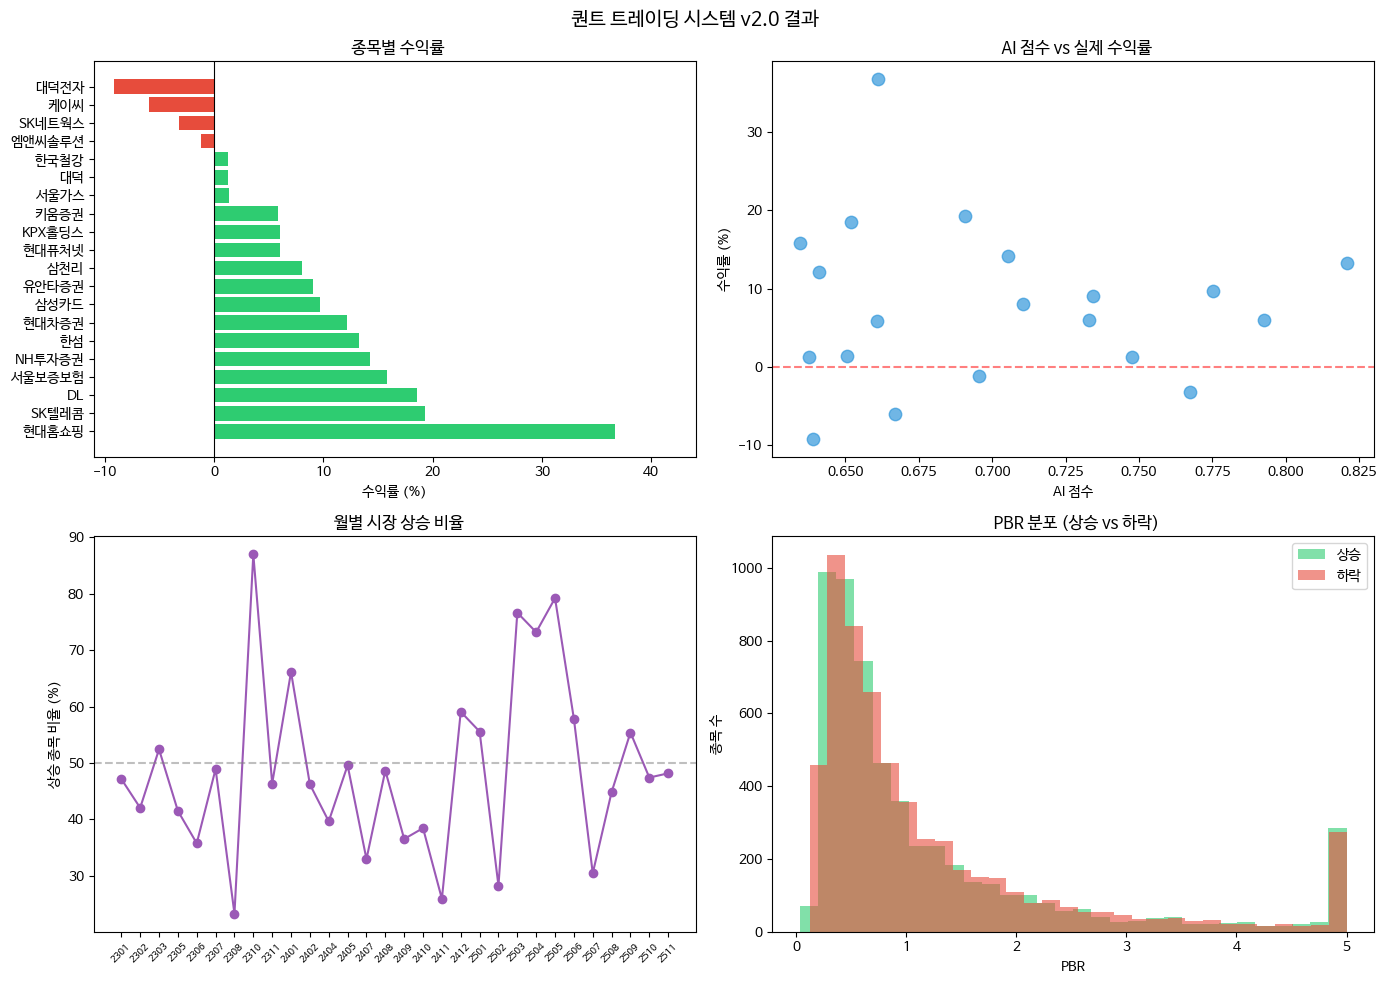

✅ 시각화 저장: quant_results_v2.png

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
🎉 전체 파이프라인 완료!
📊 학습 데이터: 11394개 샘플 (3개년)
🤖 모델: RF + GBM + LightGBM 앙상블
💰 평균 수익률: 7.96%
✅ 승률: 80.0%
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉


In [1]:
# ============================================================
# 🚀 코스피 퀀트 트레이딩 시스템 v2.0 (개선판)
# ============================================================
# 개선사항:
#   1. 학습 데이터 확대: 2023~2025년 3개년치 수집
#   2. 특성 확대: 거래량, 시총, 섹터, 배당수익률 추가 (총 12개)
#   3. 검증 방식: 랜덤 분할 → 시계열 분할 (Walk-Forward)
#   4. 앙상블 모델: RF + GBM + LightGBM 투표 방식
# ============================================================

# ============================================================
# 0. 패키지 설치
# ============================================================
!pip install pykrx pandas numpy scikit-learn lightgbm matplotlib seaborn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pykrx import stock
import time, os, pickle, warnings
from concurrent.futures import ThreadPoolExecutor, as_completed

# 모델
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

warnings.filterwarnings('ignore')
print("✅ 패키지 로드 완료")


# ============================================================
# 캐시 시스템
# ============================================================
class StockDataCache:
    def __init__(self, cache_dir='stock_cache_v2'):
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)

    def get_cache_path(self, ticker, date):
        return f"{self.cache_dir}/{ticker}_{date}.pkl"

    def save(self, ticker, date, data):
        with open(self.get_cache_path(ticker, date), 'wb') as f:
            pickle.dump(data, f)

    def load(self, ticker, date):
        path = self.get_cache_path(ticker, date)
        if os.path.exists(path):
            with open(path, 'rb') as f:
                return pickle.load(f)
        return None

cache = StockDataCache()


# ============================================================
# 유효 거래일 탐색
# ============================================================
def find_valid_date(target_date, max_days_back=5):
    date_obj = datetime.strptime(target_date, '%Y%m%d')
    for i in range(max_days_back + 1):
        check_date = (date_obj - timedelta(days=i)).strftime('%Y%m%d')
        try:
            tickers = stock.get_market_ticker_list(check_date, market="KOSPI")
            if tickers and len(tickers) > 0:
                if i > 0:
                    print(f"  📅 {target_date} → {check_date}로 보정")
                return check_date
        except:
            continue
    return None


# ============================================================
# 시총 상위 N개 종목 조회
# ============================================================
def get_top_tickers_by_market_cap(date, top_n=500):
    try:
        df_cap = stock.get_market_cap(date, market="KOSPI")
        if df_cap is not None and not df_cap.empty:
            df_sorted = df_cap.sort_values('시가총액', ascending=False)
            tickers = df_sorted.index[:top_n].tolist()
            print(f"  📊 시총 기준 상위 {len(tickers)}개 선정")
            return tickers
    except Exception as e:
        print(f"  ⚠️ 시총 조회 실패({e}), 기본 리스트 사용")

    # 폴백: 기본 리스트
    all_tickers = stock.get_market_ticker_list(date, market="KOSPI")
    return all_tickers[:top_n] if all_tickers else []


# ============================================================
# 개선 2: 특성 확대 - 단일 종목 데이터 수집
# 추가된 특성: 거래량_변화, 시가총액, 배당수익률, RSI, 볼린저밴드위치
# ============================================================
def fetch_ticker_data_v2(ticker, date):
    """확장된 특성으로 단일 종목 데이터 수집"""
    cached = cache.load(ticker, date)
    if cached is not None:
        return cached

    try:
        name = stock.get_market_ticker_name(ticker)

        # ── 펀더멘털 (PER, PBR, 배당수익률) ──────────────────
        df_fund = stock.get_market_fundamental(date, date, ticker)
        if df_fund is None or df_fund.empty:
            return None

        fund_row = df_fund.iloc[0]
        cols = fund_row.index.tolist()

        per = fund_row['PER'] if 'PER' in cols else np.nan
        pbr = fund_row['PBR'] if 'PBR' in cols else np.nan
        div_yield = fund_row['DIV'] if 'DIV' in cols else np.nan   # 배당수익률(%)

        if pd.isna(per) or pd.isna(pbr) or per <= 0 or pbr <= 0:
            return None

        # ── 시가총액 ──────────────────────────────────────────
        market_cap = np.nan
        try:
            df_cap = stock.get_market_cap(date, date, ticker)
            if df_cap is not None and not df_cap.empty:
                market_cap = df_cap['시가총액'].iloc[0] / 1e8   # 억원 단위
        except:
            pass

        # ── 가격/거래량 데이터 (200일치) ──────────────────────
        start_date = (datetime.strptime(date, '%Y%m%d') - timedelta(days=280)).strftime('%Y%m%d')
        df_price = stock.get_market_ohlcv_by_date(start_date, date, ticker)

        if df_price is None or len(df_price) < 100:
            return None

        closes = df_price['종가']
        volumes = df_price['거래량']
        highs   = df_price['고가']
        lows    = df_price['저가']

        # ── 모멘텀 ────────────────────────────────────────────
        momentum_1m = (closes.iloc[-1] / closes.iloc[-22]  - 1) * 100
        momentum_3m = (closes.iloc[-1] / closes.iloc[-66]  - 1) * 100
        momentum_6m = (closes.iloc[-1] / closes.iloc[-132] - 1) * 100 if len(df_price) > 132 else 0

        # ── 변동성 ────────────────────────────────────────────
        volatility = df_price['등락률'].tail(60).std()

        # ── 거래량 변화율 (20일 평균 대비 최근 5일) ────────────
        vol_recent = volumes.tail(5).mean()
        vol_avg20  = volumes.tail(20).mean()
        vol_change = (vol_recent / vol_avg20 - 1) * 100 if vol_avg20 > 0 else 0

        # ── RSI (14일) ────────────────────────────────────────
        delta  = closes.diff()
        gain   = delta.clip(lower=0).tail(14).mean()
        loss   = (-delta.clip(upper=0)).tail(14).mean()
        rsi    = 100 - (100 / (1 + gain / loss)) if loss != 0 else 50

        # ── 볼린저밴드 위치 (0~1, 0=하단, 1=상단) ─────────────
        ma20   = closes.tail(20).mean()
        std20  = closes.tail(20).std()
        bb_pos = (closes.iloc[-1] - (ma20 - 2*std20)) / (4*std20) if std20 > 0 else 0.5
        bb_pos = max(0, min(1, bb_pos))   # 0~1 클리핑

        # ── 52주 고저 대비 현재가 위치 ────────────────────────
        high_52w  = closes.tail(252).max() if len(closes) >= 252 else closes.max()
        low_52w   = closes.tail(252).min() if len(closes) >= 252 else closes.min()
        pos_52w   = (closes.iloc[-1] - low_52w) / (high_52w - low_52w) * 100 if (high_52w - low_52w) > 0 else 50

        result = {
            '티커':       ticker,
            '종목':       name,
            # ── 밸류에이션
            'PER':        round(per, 2),
            'PBR':        round(pbr, 2),
            '배당수익률': round(div_yield, 2) if not pd.isna(div_yield) else 0.0,
            # ── 규모
            '시가총액':   round(market_cap, 0) if not pd.isna(market_cap) else np.nan,
            # ── 모멘텀
            '모멘텀_1m':  round(momentum_1m, 2),
            '모멘텀_3m':  round(momentum_3m, 2),
            '모멘텀_6m':  round(momentum_6m, 2),
            # ── 리스크/기술적
            '변동성':     round(volatility, 2),
            '거래량변화': round(vol_change, 2),
            'RSI':        round(rsi, 2),
            '볼린저위치': round(bb_pos, 4),
            '52주위치':   round(pos_52w, 2),
            # ── 가격
            '현재가':     closes.iloc[-1],
        }

        cache.save(ticker, date, result)
        return result

    except Exception as e:
        return None


# ============================================================
# 월별 데이터 수집 (병렬, Rate Limit 보호)
# ============================================================
def collect_month_data_v2(date, top_n=500, max_workers=3):
    print(f"📅 {date} 수집 시작...")

    tickers = get_top_tickers_by_market_cap(date, top_n)
    if not tickers:
        print(f"  ⚠️ {date}: 종목 없음")
        return pd.DataFrame()

    print(f"  📋 수집 대상: {len(tickers)}개")
    results = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(fetch_ticker_data_v2, t, date): t for t in tickers}
        for i, future in enumerate(as_completed(futures)):
            res = future.result()
            if res is not None:
                res['기준일'] = date
                results.append(res)
            if i % 50 == 49:
                time.sleep(1)   # Rate Limit 보호

    df = pd.DataFrame(results)
    print(f"  ✅ 성공: {len(df)}개 / 전체: {len(tickers)}개")
    return df


# ============================================================
# 개선 1: 학습 데이터 확대 - 2023~2025년 3개년 수집
# ============================================================
def collect_multi_year_data(start_year=2023, end_year=2025, top_n=500):
    """
    start_year ~ end_year 의 월말 거래일 데이터를 모두 수집
    """
    # 각 연도의 월말 기준일 생성
    month_targets = []
    for year in range(start_year, end_year + 1):
        month_ends = [
            f'{year}0131', f'{year}0228', f'{year}0331', f'{year}0430',
            f'{year}0530', f'{year}0630', f'{year}0731', f'{year}0829',
            f'{year}0930', f'{year}1031', f'{year}1128', f'{year}1230',
        ]
        # 윤년 처리 (2024년 2월)
        if year == 2024:
            month_ends[1] = '20240229'
        month_targets.extend(month_ends)

    print(f"📊 {start_year}~{end_year}년 실제 거래일 확인중 ({len(month_targets)}개월)...")
    valid_months = []
    for m in month_targets:
        valid = find_valid_date(m)
        if valid:
            valid_months.append(valid)
        else:
            print(f"  ❌ {m}: 유효 거래일 없음")

    print(f"\n✅ 수집 대상: {len(valid_months)}개월\n")

    all_data = []
    start_time = time.time()

    for i, month in enumerate(valid_months, 1):
        print(f"\n[{i}/{len(valid_months)}] ", end="")
        df_month = collect_month_data_v2(month, top_n=top_n)

        if df_month is not None and not df_month.empty:
            all_data.append(df_month)

        time.sleep(2)   # 월간 딜레이
        elapsed   = time.time() - start_time
        remaining = (elapsed / i) * (len(valid_months) - i)
        print(f"  ⏱️ 경과: {elapsed:.0f}초 / 잔여: {remaining:.0f}초")

    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)
        print(f"\n✅ 수집 완료: {len(final_df)}개 샘플, {final_df['기준일'].nunique()}개월")
        return final_df
    else:
        print("❌ 수집 실패")
        return pd.DataFrame()


# ============================================================
# 다음달 수익률 추가 (레이블 생성)
# ============================================================
def add_future_returns(df):
    if df.empty:
        return pd.DataFrame()

    results = []
    for ticker, group in df.groupby('티커'):
        group = group.sort_values('기준일').reset_index(drop=True)
        if len(group) < 2:
            continue
        for i in range(len(group) - 1):
            row = group.iloc[i].to_dict()
            next_price = group.iloc[i + 1]['현재가']
            ret = (next_price / row['현재가'] - 1) * 100
            row['다음달수익률'] = round(ret, 2)
            row['target'] = 1 if ret > 0 else 0
            results.append(row)

    df_result = pd.DataFrame(results)
    print(f"✅ 학습 샘플: {len(df_result)}개 / 종목 수: {df_result['티커'].nunique()}개")

    # 월별 분포 확인
    monthly = df_result.groupby('기준일')['target'].agg(['count', 'mean'])
    monthly.columns = ['샘플수', '상승비율']
    monthly['상승비율'] = monthly['상승비율'].apply(lambda x: f"{x:.1%}")
    print(f"\n📈 월별 학습 데이터:")
    print(monthly.to_string())
    return df_result


# ============================================================
# 개선 3: 시계열 분할 (Walk-Forward Validation)
# 개선 4: 앙상블 모델 (RF + GBM + LightGBM)
# ============================================================
FEATURE_COLS = [
    'PER', 'PBR', '배당수익률',          # 밸류에이션
    '시가총액',                            # 규모
    '모멘텀_1m', '모멘텀_3m', '모멘텀_6m',# 모멘텀
    '변동성', '거래량변화',                # 리스크
    'RSI', '볼린저위치', '52주위치',       # 기술적 지표
]

def build_ensemble_model():
    """RF + GBM + LightGBM 앙상블"""
    rf = RandomForestClassifier(
        n_estimators=200, max_depth=8,
        min_samples_split=10, random_state=42, n_jobs=-1
    )
    gbm = GradientBoostingClassifier(
        n_estimators=150, max_depth=4,
        learning_rate=0.05, random_state=42
    )
    lgbm = lgb.LGBMClassifier(
        n_estimators=200, max_depth=6,
        learning_rate=0.05, num_leaves=31,
        random_state=42, n_jobs=-1, verbose=-1
    )
    # 소프트 보팅: 확률 평균
    ensemble = VotingClassifier(
        estimators=[('rf', rf), ('gbm', gbm), ('lgbm', lgbm)],
        voting='soft',
        n_jobs=-1
    )
    return ensemble


def train_with_timeseries_cv(df_train):
    """
    시계열 교차검증 (Walk-Forward)
    - 과거 데이터로 학습 → 미래 데이터로 검증 (데이터 누수 방지)
    """
    df = df_train.dropna(subset=FEATURE_COLS).copy()

    # 기준일을 숫자 인덱스로 변환 (시계열 순 정렬)
    df = df.sort_values('기준일').reset_index(drop=True)
    dates = sorted(df['기준일'].unique())

    print(f"\n{'='*60}")
    print(f"🤖 앙상블 모델 시계열 교차검증")
    print(f"{'='*60}")
    print(f"📊 총 샘플: {len(df)}개 / {len(dates)}개월")
    print(f"📋 사용 특성 ({len(FEATURE_COLS)}개): {FEATURE_COLS}\n")

    # ── 시계열 분할: 최소 12개월 학습, 1개월씩 검증 ──────────
    n_splits    = min(6, len(dates) - 12)   # 검증 폴드 수
    fold_accs   = []
    fold_aucs   = []

    for fold in range(n_splits):
        split_idx   = len(dates) - n_splits + fold
        train_dates = dates[:split_idx]
        val_dates   = [dates[split_idx]]

        df_tr  = df[df['기준일'].isin(train_dates)]
        df_val = df[df['기준일'].isin(val_dates)]

        if len(df_tr) < 100 or len(df_val) < 10:
            continue

        X_tr  = df_tr[FEATURE_COLS].values
        y_tr  = df_tr['target'].values
        X_val = df_val[FEATURE_COLS].values
        y_val = df_val['target'].values

        scaler    = StandardScaler()
        X_tr_sc   = scaler.fit_transform(X_tr)
        X_val_sc  = scaler.transform(X_val)

        model = build_ensemble_model()
        model.fit(X_tr_sc, y_tr)

        y_pred  = model.predict(X_val_sc)
        y_prob  = model.predict_proba(X_val_sc)[:, 1]
        acc     = accuracy_score(y_val, y_pred)
        auc     = roc_auc_score(y_val, y_prob) if len(np.unique(y_val)) > 1 else 0.5

        fold_accs.append(acc)
        fold_aucs.append(auc)
        print(f"  Fold {fold+1} | 학습: {train_dates[0]}~{train_dates[-1]} | "
              f"검증: {val_dates[0]} | ACC: {acc:.3f} | AUC: {auc:.3f}")

    print(f"\n{'='*60}")
    print(f"📊 교차검증 결과")
    print(f"  평균 정확도: {np.mean(fold_accs):.3f} ± {np.std(fold_accs):.3f}")
    print(f"  평균 AUC:   {np.mean(fold_aucs):.3f} ± {np.std(fold_aucs):.3f}")
    print(f"{'='*60}\n")

    # ── 전체 데이터로 최종 모델 학습 ─────────────────────────
    print("🤖 전체 데이터로 최종 모델 학습중...")
    X_all    = df[FEATURE_COLS].values
    y_all    = df['target'].values
    scaler   = StandardScaler()
    X_all_sc = scaler.fit_transform(X_all)

    final_model = build_ensemble_model()
    final_model.fit(X_all_sc, y_all)
    print("✅ 최종 모델 학습 완료")

    # ── 특성 중요도 (RF 기준) ─────────────────────────────────
    try:
        rf_model    = final_model.estimators_[0]  # RF
        importance  = pd.DataFrame({
            '특성':   FEATURE_COLS,
            '중요도': rf_model.feature_importances_
        }).sort_values('중요도', ascending=False)
        print(f"\n🏆 특성 중요도 (RandomForest 기준):")
        print(importance.to_string(index=False))
    except:
        pass

    return final_model, scaler, FEATURE_COLS


# ============================================================
# 2026년 1월 투자 종목 선정
# ============================================================
def select_stocks_jan2026_v2(model, scaler, features, date='20260130', top_n=500):
    valid_date = find_valid_date(date)
    if not valid_date:
        print("❌ 유효 거래일 없음")
        return pd.DataFrame()

    print(f"\n📅 {valid_date} 데이터 수집중...")
    tickers = get_top_tickers_by_market_cap(valid_date, top_n)
    if not tickers:
        return pd.DataFrame()

    stock_data = []
    for ticker in tickers:
        res = fetch_ticker_data_v2(ticker, valid_date)
        if res is not None:
            res['기준일'] = valid_date
            stock_data.append(res)
        time.sleep(0.02)   # 소량 딜레이

    df_jan = pd.DataFrame(stock_data)
    print(f"✅ {len(df_jan)}개 종목 수집 완료")

    if df_jan.empty:
        return pd.DataFrame()

    # 결측치 처리
    df_jan_clean = df_jan.dropna(subset=features)
    print(f"✅ 결측치 제거 후: {len(df_jan_clean)}개")

    X_jan = scaler.transform(df_jan_clean[features].values)
    df_jan_clean = df_jan_clean.copy()
    df_jan_clean['AI_점수'] = model.predict_proba(X_jan)[:, 1]

    top_20 = df_jan_clean.nlargest(20, 'AI_점수')

    print("\n" + "="*80)
    print(f"💰 {valid_date} 투자 선정 종목 TOP 20")
    print("="*80)
    display_cols = ['종목', 'PER', 'PBR', '배당수익률', '모멘텀_1m', 'RSI', 'AI_점수']
    print(top_20[display_cols].to_string(index=False))
    return top_20


# ============================================================
# 2026년 2월 성과 확인
# ============================================================
def check_feb_results_v2(portfolio_jan, date='20260213'):
    valid_date = find_valid_date(date)
    if not valid_date:
        print("❌ 유효 거래일 없음")
        return pd.DataFrame()

    print(f"\n📅 {valid_date} 성과 확인중...")
    results = []

    for _, row in portfolio_jan.iterrows():
        ticker    = row['티커']
        buy_price = row['현재가']
        try:
            df_feb = stock.get_market_ohlcv_by_date(valid_date, valid_date, ticker)
            if df_feb is None or df_feb.empty:
                continue
            feb_price = df_feb['종가'].iloc[0]
            ret       = (feb_price / buy_price - 1) * 100
            results.append({
                '종목':     row['종목'],
                '매수가':   buy_price,
                '현재가':   feb_price,
                '수익률(%)': round(ret, 2),
                'AI_점수':  round(row['AI_점수'], 3),
            })
        except:
            continue

    df_res = pd.DataFrame(results).sort_values('수익률(%)', ascending=False)

    print("\n" + "="*60)
    print("📈 2월 성과 결과")
    print("="*60)
    print(df_res.to_string(index=False))
    print(f"\n{'='*60}")
    print(f"✅ 분석 종목:   {len(df_res)}개")
    print(f"✅ 평균 수익률: {df_res['수익률(%)'].mean():.2f}%")
    print(f"✅ 중앙값:      {df_res['수익률(%)'].median():.2f}%")
    print(f"✅ 상승 종목:   {len(df_res[df_res['수익률(%)'] > 0])}개")
    print(f"✅ 하락 종목:   {len(df_res[df_res['수익률(%)'] < 0])}개")
    print(f"✅ 승률:        {len(df_res[df_res['수익률(%)']>0]) / len(df_res) * 100:.1f}%")
    return df_res


# ============================================================
# 결과 시각화
# ============================================================
def visualize_results(df_res, df_train, portfolio_jan):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('퀀트 트레이딩 시스템 v2.0 결과', fontsize=14, fontweight='bold')

    # 1. 수익률 분포
    ax1 = axes[0, 0]
    colors = ['#e74c3c' if r < 0 else '#2ecc71' for r in df_res['수익률(%)']]
    bars = ax1.barh(df_res['종목'], df_res['수익률(%)'], color=colors)
    ax1.axvline(x=0, color='black', linewidth=0.8)
    ax1.set_xlabel('수익률 (%)')
    ax1.set_title('📈 종목별 수익률')
    ax1.set_xlim(df_res['수익률(%)'].min() * 1.2, df_res['수익률(%)'].max() * 1.2)

    # 2. AI 점수 vs 수익률
    ax2 = axes[0, 1]
    ax2.scatter(portfolio_jan['AI_점수'], df_res.set_index('종목').reindex(portfolio_jan['종목'])['수익률(%)'],
                alpha=0.7, s=80, color='#3498db')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax2.set_xlabel('AI 점수')
    ax2.set_ylabel('수익률 (%)')
    ax2.set_title('🤖 AI 점수 vs 실제 수익률')

    # 3. 월별 상승 비율 (학습 데이터)
    ax3 = axes[1, 0]
    monthly_up = df_train.groupby('기준일')['target'].mean() * 100
    ax3.plot(range(len(monthly_up)), monthly_up.values, marker='o', color='#9b59b6')
    ax3.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    ax3.set_xticks(range(len(monthly_up)))
    ax3.set_xticklabels([d[2:6] for d in monthly_up.index], rotation=45, fontsize=7)
    ax3.set_ylabel('상승 종목 비율 (%)')
    ax3.set_title('📊 월별 시장 상승 비율')

    # 4. 특성별 분포 (PBR)
    ax4 = axes[1, 1]
    up_pbr   = df_train[df_train['target'] == 1]['PBR'].clip(0, 5)
    down_pbr = df_train[df_train['target'] == 0]['PBR'].clip(0, 5)
    ax4.hist(up_pbr,   bins=30, alpha=0.6, color='#2ecc71', label='상승')
    ax4.hist(down_pbr, bins=30, alpha=0.6, color='#e74c3c', label='하락')
    ax4.set_xlabel('PBR')
    ax4.set_ylabel('종목 수')
    ax4.set_title('📊 PBR 분포 (상승 vs 하락)')
    ax4.legend()

    plt.tight_layout()
    plt.savefig('quant_results_v2.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ 시각화 저장: quant_results_v2.png")


# ============================================================
# 메인 실행
# ============================================================
if __name__ == '__main__':
    print("\n" + "🚀"*30)
    print("🚀 퀀트 트레이딩 시스템 v2.0 시작")
    print("🚀"*30 + "\n")

    # ── Step 1: 2023~2025년 3개년 데이터 수집 ─────────────────
    print("=" * 60)
    print("Step 1. 2023~2025년 데이터 수집 (시총 상위 500개)")
    print("=" * 60)
    df_raw = collect_multi_year_data(start_year=2023, end_year=2025, top_n=500)

    if df_raw.empty:
        print("❌ 데이터 수집 실패. 종료.")
    else:
        # ── Step 2: 레이블(다음달 수익률) 생성 ────────────────
        print("\n" + "=" * 60)
        print("Step 2. 학습 레이블 생성 (다음달 수익률)")
        print("=" * 60)
        df_train = add_future_returns(df_raw)

        if df_train.empty:
            print("❌ 학습 데이터 생성 실패. 종료.")
        else:
            # ── Step 3: 앙상블 모델 + 시계열 교차검증 ────────
            print("\n" + "=" * 60)
            print("Step 3. 앙상블 모델 학습 (시계열 교차검증)")
            print("=" * 60)
            model, scaler, features = train_with_timeseries_cv(df_train)

            # ── Step 4: 2026년 1월 종목 선정 ─────────────────
            print("\n" + "=" * 60)
            print("Step 4. 2026년 1월 투자 종목 선정")
            print("=" * 60)
            portfolio_jan = select_stocks_jan2026_v2(model, scaler, features)

            if not portfolio_jan.empty:
                # ── Step 5: 2월 성과 확인 ─────────────────────
                print("\n" + "=" * 60)
                print("Step 5. 2026년 2월 성과 확인")
                print("=" * 60)
                feb_results = check_feb_results_v2(portfolio_jan)

                # ── Step 6: 시각화 ─────────────────────────────
                print("\n" + "=" * 60)
                print("Step 6. 결과 시각화")
                print("=" * 60)
                try:
                    visualize_results(feb_results, df_train, portfolio_jan)
                except Exception as e:
                    print(f"⚠️ 시각화 실패: {e}")

                print("\n" + "🎉"*30)
                print("🎉 전체 파이프라인 완료!")
                print(f"📊 학습 데이터: {len(df_train)}개 샘플 (3개년)")
                print(f"🤖 모델: RF + GBM + LightGBM 앙상블")
                print(f"💰 평균 수익률: {feb_results['수익률(%)'].mean():.2f}%")
                print(f"✅ 승률: {len(feb_results[feb_results['수익률(%)']>0])/len(feb_results)*100:.1f}%")
                print("🎉"*30)
            else:
                print("❌ 포트폴리오 선정 실패")